# TME2 : Algorithmes génétiques et Recherche locale

Binôme : Valentin COLLIARD et Madina TRAORE

### Exercice 1 : Mise en œuvre d’un algorithme génétique

#### Question 1

On ne peut pas faire de **croisement à un point** si l'on utilise un **codage direct** car cela peut engendrer des solutions non réalisables.

*Exemple : Soient 4 villes 1,2,3 et 4 et deux chemins x = (1,2,3,4) et y = (1,3,2,4) permettant de toutes les visiter une et une seule fois. En réalisant un croisement à un point avec π = 2, on obtiendrait un fils z = (1,2,2,4) : la ville 2 serait donc visitée deux fois, la ville 3 ne le serait jamais et z ne serait alors pas une solution acceptable pour le TSP.*

<br>
Par ailleurs, on ne peut pas faire de **croisement à un point fondé sur le rang** si l'on utilise un **codage ordinal** car dans certaines situations on ne pourrait même pas parvenir à définir le fils.

*Exemple : Soient 4 villes 1,2,3 et 4 et deux chemins x = (1,2,3,4) et y = (3,4,2,1) permettant de toutes les visiter une et une seule fois.
Le codage ordinal correspondant à x est x' = (1,1,1,1) et celui correspondant à y est y' = (3,3,2,1). En réalisant un croisement à un point fondé sur le rang avec p = 2, on obtiendrait un fils de codage ordinal z' = (1,1,3,2) : il serait alors impossible d'obtenir le codage direct z correspondant à ce fils. En effet, il n'y a que 4 villes donc après avoir visité les villes 1 et 2 il n'existe plus de ville d'ordre 3 (il ne reste plus que deux villes : les villes 3 et 4 d'ordres respectifs 1 et 2).*

#### Question 2

L'opérateur de mutation que nous utiliserons aura pour effet d'échanger deux villes choisies de manière aléatoire au sein d'une solution réalisable z.

*Exemple : Le fils z = (1,2,3,4) pourra muter en z' = (1,3,2,4)*

In [1]:
def mutation(z, nbCities):
    k1 = np.random.randint(0,nbCities)
    k2 = np.random.randint(0,nbCities)
    while k1 == k2:
        k2 = np.random.randint(0,nbCities)
    tmp = z[k1]
    z[k1] = z[k2]
    z[k2] = tmp
    return z

#### Question 3

Les deux parents à croiser seront choisis aléatoirement parmi les individus ayant la meilleure fitness (10 meilleurs individus par exemple).

In [2]:
def selection(e_meilleurs_individus,F,P):
    ind_x = np.random.randint(0,len(e_meilleurs_individus))
    ind_y = np.random.randint(0,len(e_meilleurs_individus))
    while ind_x == ind_y:
        ind_y = np.random.randint(0,len(e_meilleurs_individus))
    ex = e_meilleurs_individus[ind_x]
    ey = e_meilleurs_individus[ind_y]
    x = P[F.index(ex)]
    y = P[F.index(ey)]
    return x,y

On réalisera un croisement à un point fondé sur le rang. 

In [3]:
def croisement(x,y):
    p = np.random.randint(0,nbCities)
    z1 = x[:p]
    z1 += [city for city in y if city not in z1]
    z2 = y[:p]
    z2 += [city for city in x if city not in z2]
    return z1,z2

Fonctions provenant du fichier TSP.py et permettant de lire des instances au format .tsp, de calculer la fitness d'un individu et d’afficher des solutions réalisables (tournées) :

In [4]:
import re,numpy as np, random, operator, time, matplotlib.pyplot as plt
from scipy.interpolate import spline

#Function to read the content of a .tsp file from the tsplib library

def read_tsp_data(tsp_name):
    tsp_name = tsp_name
    with open(tsp_name) as f:
        content = f.read().splitlines()
        cleaned = [x.lstrip() for x in content if x != ""]
        return cleaned


#Function to obtain the number of cities from the instance

def detect_dimension(in_list):
    non_numeric = re.compile(r'[^\d]+')
    for element in in_list:
        if element.startswith("DIMENSION"):
            return non_numeric.sub("",element)

#Function to get the list of cities
 
def get_cities(list,dimension):
    cities_set = []
    dimension = int(dimension)
    for item in list:
        for num in range(1, dimension + 1):
            if item.startswith(str(num)):
                index, space, rest = item.partition(' ')
                if rest not in cities_set:
                    cities_set.append(rest)
    return cities_set


#Function to brake each coordinate to a tuple

def city_tup(list):
    cities_tups = []
    for item in list:
        first_coord, space, second_coord = item.partition(' ')
        cities_tups.append((float(first_coord.strip()), float(second_coord.strip())))
    return cities_tups

#Function to get the cities as a dictionary

def create_cities_dict(cities_tups):
    return dict(zip((range(1,len(cities_tups)+1)),cities_tups))

def read_tsp(dimension,data):
    cities_dict = create_cities_dict(city_tup(get_cities(data,dimension)))
    return cities_dict

#Function to evaluate an individual

def evaluation(individu,cities):
    distance = 0.0
    for i in range(0, len(individu)):
        fromCity = individu[i]
        toCity = None
        if i+1 < len(individu):
            toCity = individu[i+1]
        else:
            toCity = individu[0]
        xDiff = cities.get(fromCity)[0]-cities.get(toCity)[0]
        yDiff = cities.get(fromCity)[1]-cities.get(toCity)[1]
        distance += round(np.sqrt((xDiff ** 2) + (yDiff ** 2)))
    return distance

#Function to a display a tour

def plottour(instance,individu,cities):
    plt.figure(figsize=(8, 10), dpi=100)  
    plt.title('Traveling Salesman : ' + instance)
    for point in cities.values():
        plt.plot(point[0],point[1],'ro')
    x=[]
    y=[]
    for i in range(0, len(individu)):
        x.append(cities.get(individu[i])[0])
        y.append(cities.get(individu[i])[1])

    #retour ville de départ
    x.append(cities.get(individu[0])[0])
    y.append(cities.get(individu[0])[1])

    plt.plot(x,y,color='black', lw=1)
    
    #plt.ion()
    plt.show()
    #plt.pause(5) 

#### Question 4

In [5]:
def algorithme_genetique(N, NbG, pm, cities, nbCities, affichages = False):
    P = [] #population = ensemble de N itinéraires (= N solutions possibles pour le TSP)
    for i in range(N):
        P.append(random.sample(range(1,nbCities+1),nbCities))
    individuOptimal = P[0]
    nbg = []
    fitness = []
    for k in range(NbG):
        nbg.append(k)
        F = [] #liste des fitness de chaque individu de la population
        for i in range(N):
            F.append(1/evaluation(P[i],cities))
        F_triee = sorted(F)
        f_max = F_triee[-1]
        e_min = 1/f_max
        fitness.append(e_min)
        if affichages:
            print("Génération",k," --> Evaluation individu optimal :",int(round(e_min)))
        individuOptimal = P[F.index(f_max)]
        F_10 = F_triee[-10:]
        newP = []
        for i in range(N//2):
            # Sélection : on choisit aléatoirement 2 individus parmi les 10 individus ayant la meilleure fitness)
            x,y = selection(F_10,F,P)
            # Croisement : on réalise un croisement à un point fondé sur le rang
            z1,z2 = croisement(x,y)
            # Mutation : les nouveaux individus z1 et z2 sont modifiés avec une probabilité pm (deux de leurs villes
            # sont permutées de manière aléatoire)
            if random.random() <= pm:
                z1 = mutation(z1,nbCities)
                z2 = mutation(z2,nbCities)
            # Insertion des nouveaux individus dans newP
            newP.append(z1)
            newP.append(z2)
        P = newP
    return individuOptimal,nbg,fitness

**Performances de l'algorithme génétique implémenté**

Instance kroA100

Nombre de générations : 500
Pourcentage de mutation : 0.4


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


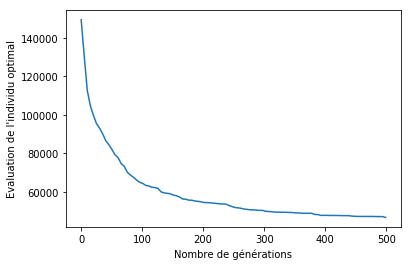

Evaluation de la solution finale : 46709.0


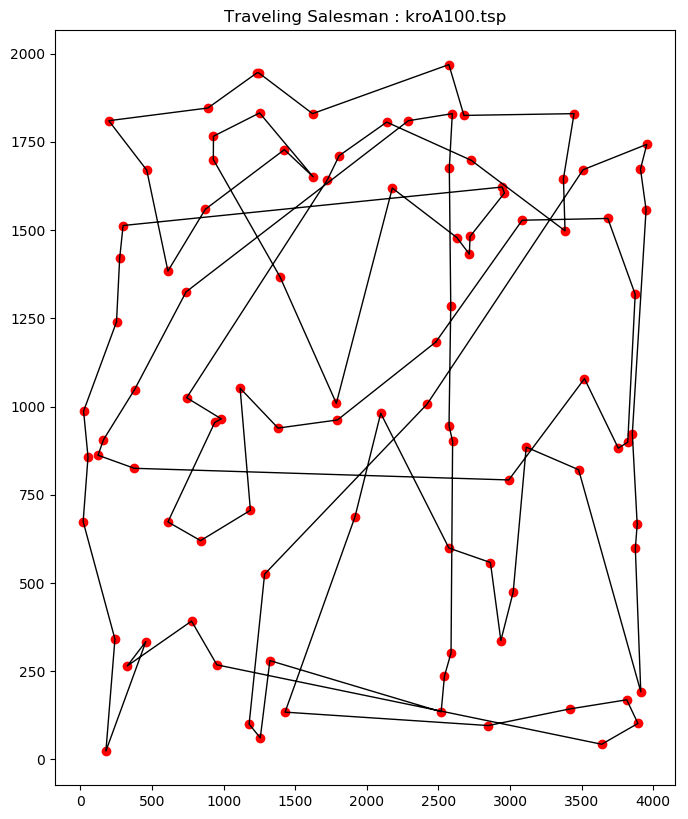

In [6]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.4
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
fitness = []
individuOptimal,nbg,fitness = algorithme_genetique(N,NbG,pm,cities, nbCities)

new_nbg = np.linspace(min(nbg),max(nbg),100)

fitness_smooth = spline(nbg,fitness,new_nbg)

plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,fitness_smooth)
plt.show()

print('Evaluation de la solution finale :',evaluation(individuOptimal,cities))
plottour(instance,individuOptimal,cities)

Instance kroB100

Nombre de générations : 500
Pourcentage de mutation : 0.4


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


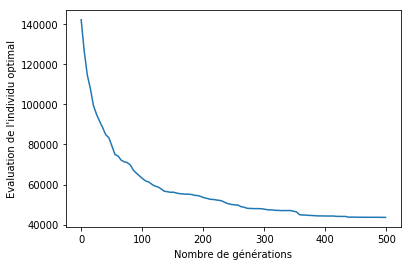

Evaluation de la solution finale : 43552.0


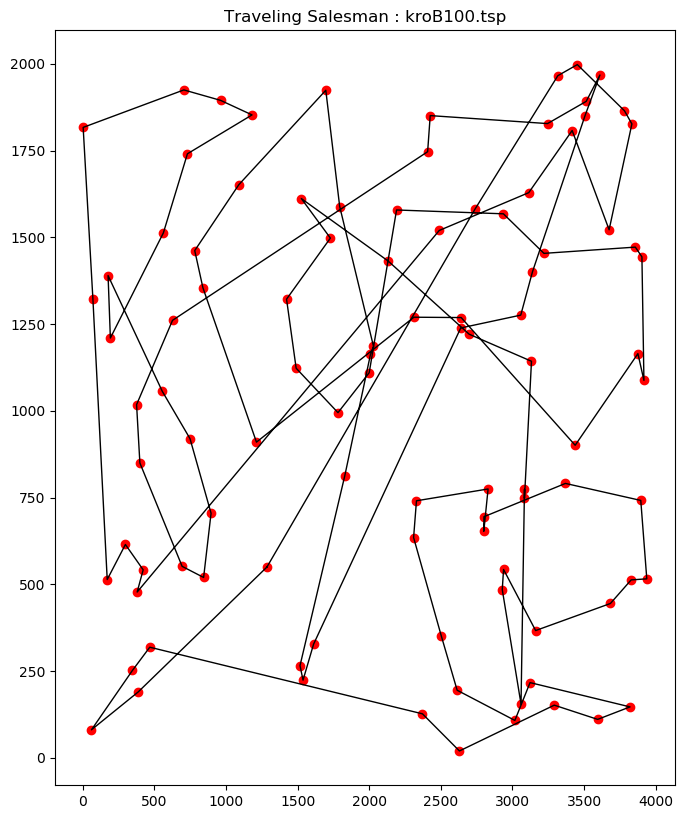

In [7]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.4
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
fitness = []
individuOptimal,nbg,fitness = algorithme_genetique(N,NbG,pm,cities, nbCities)

new_nbg = np.linspace(min(nbg),max(nbg),100)

fitness_smooth = spline(nbg,fitness,new_nbg)

plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,fitness_smooth)
plt.show()

print('Evaluation de la solution finale :',evaluation(individuOptimal,cities))
plottour(instance,individuOptimal,cities)

Instance kroC100

Nombre de générations : 500
Pourcentage de mutation : 0.4


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


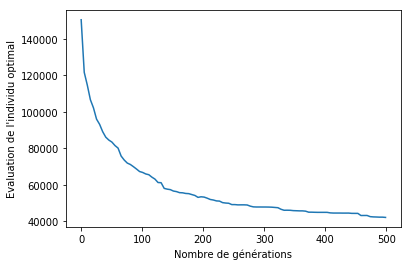

Evaluation de la solution finale : 42146.0


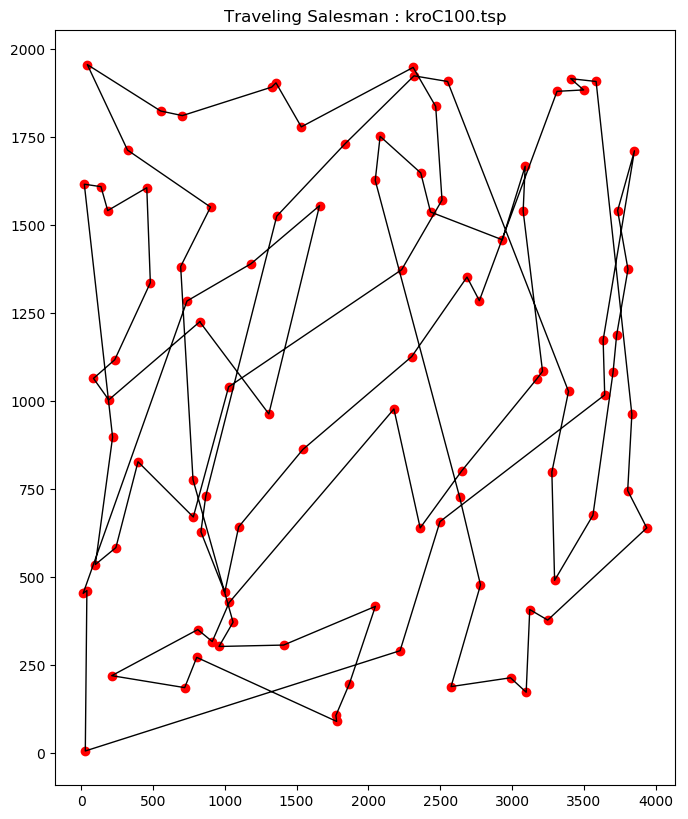

In [8]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.4
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
fitness = []
individuOptimal,nbg,fitness = algorithme_genetique(N,NbG,pm,cities, nbCities)

new_nbg = np.linspace(min(nbg),max(nbg),100)

fitness_smooth = spline(nbg,fitness,new_nbg)

plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,fitness_smooth)
plt.show()

print('Evaluation de la solution finale :',evaluation(individuOptimal,cities))
plottour(instance,individuOptimal,cities)

Instance kroD100

Nombre de générations : 500
Pourcentage de mutation : 0.4


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


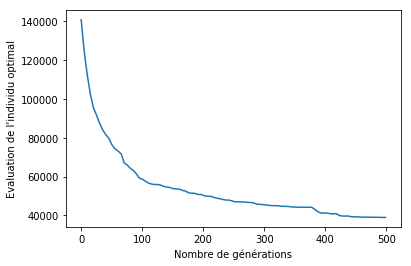

Evaluation de la solution finale : 38898.0


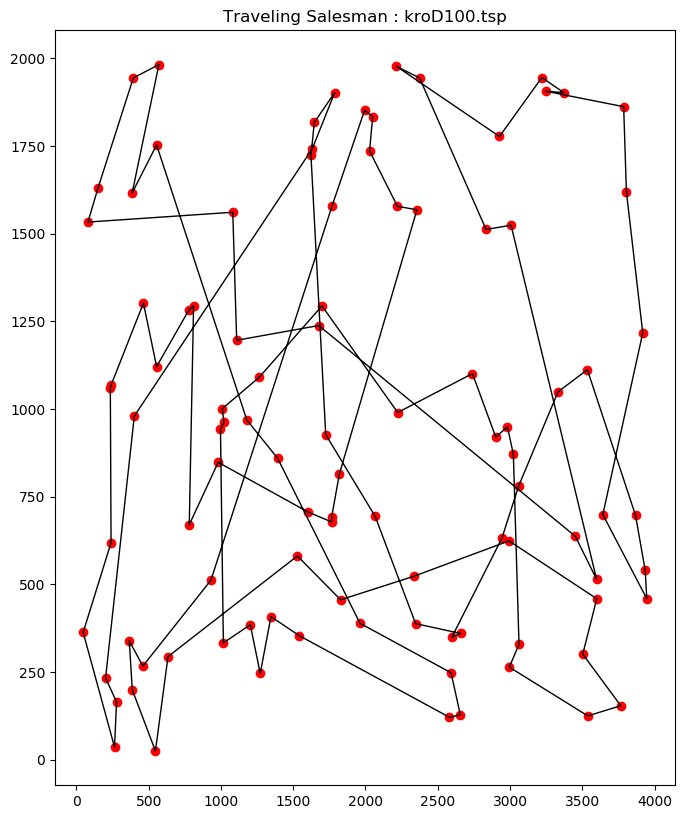

In [9]:
instance = "kroD100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.4
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
fitness = []
individuOptimal,nbg,fitness = algorithme_genetique(N,NbG,pm,cities, nbCities)

new_nbg = np.linspace(min(nbg),max(nbg),100)

fitness_smooth = spline(nbg,fitness,new_nbg)

plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,fitness_smooth)
plt.show()

print('Evaluation de la solution finale :',evaluation(individuOptimal,cities))
plottour(instance,individuOptimal,cities)

Instance kroE100

Nombre de générations : 500
Pourcentage de mutation : 0.4


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


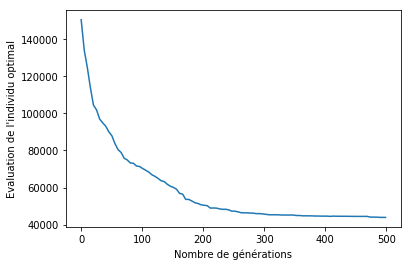

Evaluation de la solution finale : 43873.0


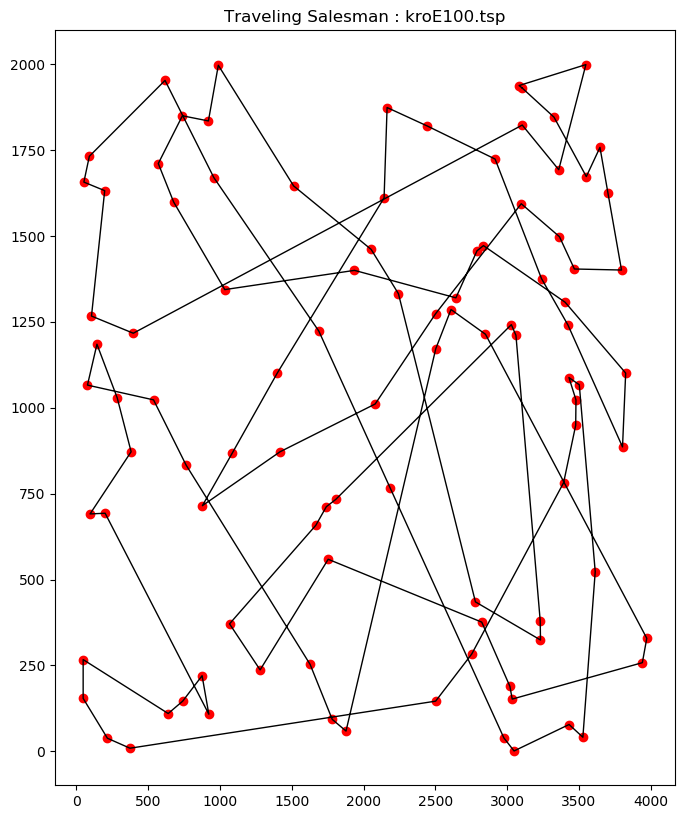

In [10]:
instance = "kroE100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.4
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
fitness = []
individuOptimal,nbg,fitness = algorithme_genetique(N,NbG,pm,cities, nbCities)

new_nbg = np.linspace(min(nbg),max(nbg),100)

fitness_smooth = spline(nbg,fitness,new_nbg)

plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,fitness_smooth)
plt.show()

print('Evaluation de la solution finale :',evaluation(individuOptimal,cities))
plottour(instance,individuOptimal,cities)

Pour chaque instance on remarque que la courbe d'évaluation du meilleur individu de chaque génération en fonction du nombre de générations a une allure de fonction inverse : les solutions s'améliorent de manière significative au cours des premières générations (générations 0 à 50), continuent à s'améliorer plus faiblement (générations 50 à 400) puis finissent par s'améliorer très sensiblement voire par stagner (générations 400 à 500).  

### Exercice 2 : Amélioration grâce à la recherche locale

#### Question 1

On effectuera une descente par meilleure amélioration. Les voisins d'une solution seront obtenus en permutant l'ordre de deux sommets consécutifs dans celle-ci (sans modifier le sommet de départ).

In [11]:
def recherche_locale(best_sol,cities):
    meilleure_sol = None # meilleure solution rencontrée au cours de la descente
    x = best_sol # solution que l'on explore
    c = False # booléen indiquant si un voisin améliorant a été trouvé ou non
    B = []
    e_B = []
    e_min = evaluation(x,cities)
    while x != meilleure_sol:
        meilleure_sol = x
        B.append(x)
        V = [] # liste des voisins de la solution que l'on explore
        for i in range(1,len(x)-1):
            v = x[:i]
            v.append(x[i+1])
            v.append(x[i])
            v += x[i+2:]
            V.append(v)
        e_V = [evaluation(y,cities) for y in V]
        for i in range(len(V)):
            ex = evaluation(x,cities)
            ey = e_V[i]
            if ey < ex:
                c = True
                x = V[i]
                B = [V[i]]
                e_B = [ey]
            elif ey == ex:
                B.append(V[i])
                e_B.append(ey)
        if e_B:
            e_min = min(e_B)
            x = B[e_B.index(e_min)]
    return x

Nombre de générations : 500
Pourcentage de mutation : 0.5
Meilleure solution trouvée avec l'algorithme génétique pour l'instance kroA100.tsp : 38823.0
Résultat de la recherche locale : 38742.0


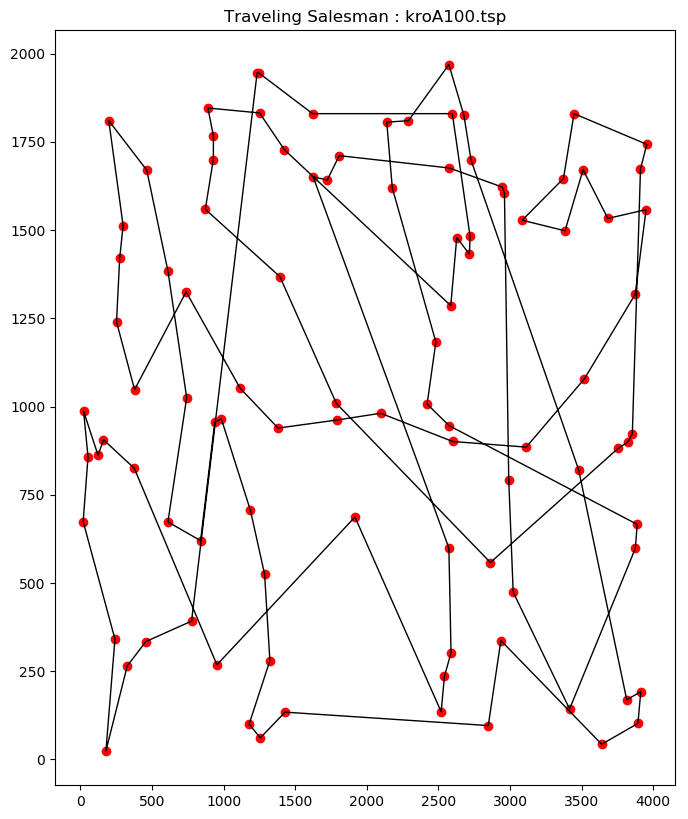

In [56]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.5
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
print("Meilleure solution trouvée avec l'algorithme génétique pour l'instance",instance,":",evaluation(individuOptimal,cities))
voisiOptimal = recherche_locale(individuOptimal,cities)
print("Résultat de la recherche locale :",evaluation(voisiOptimal,cities))
plottour(instance,voisiOptimal,cities)

En effectuant une recherche locale à partir de la solution optimale trouvée avec l'algorithme génétique (évaluée à 38823.0) on trouve un voisin améliorant d'évaluation 38742.0. Il arrive que l'on soit déjà sur un optimum local et qu'on ne trouve donc pas de voisin améliorant.

#### Question 2

In [13]:
def algorithme_memetique1(N, NbG, pm, cities, nbCities):
    N = 100
    P = [] #population = ensemble de N itinéraires (= N solutions possibles pour le TSP)
    for i in range(N):
        P.append(random.sample(range(1,nbCities+1),nbCities))
    individuOptimal = P[0]
    nbg = []
    evaluations = []
    for k in range(NbG):
        nbg.append(k)
        F = [] #liste des fitness de chaque individu de la population
        for i in range(N):
            F.append(1/evaluation(P[i],cities))
        F_triee = sorted(F)
        f_max = F_triee[-1]
        e_min = 1/f_max
        evaluations.append(e_min)
        individuOptimal = P[F.index(f_max)]
        #print("Génération",k," --> Evaluation individu optimal :",int(round(e_min)))
        F_10 = F_triee[-10:]
        newP = []
        for i in range(N//2):
            # Sélection : on choisit aléatoirement 2 individus parmi les 10 individus ayant la meilleure fitness)
            x,y = selection(F_10,F,P)
            # Croisement : on réalise un croisement à un point fondé sur le rang
            z1,z2 = croisement(x,y)
            # Mutation : on applique une recherche locale sur les individus z1 et z2 avec une probabilité pm
            if random.random() <= pm:
                #chercher dans les voisins de z1 et z2 des meileures solutions grace a la recherche locale
                #print("Recherche locale z1")
                z1 = recherche_locale(z1,cities)
                #print("Recherche locale z2")
                z2 = recherche_locale(z2,cities)
            # Insertion des nouveaux individus dans newP
            newP.append(z1)
            newP.append(z2)
        P = newP
    return individuOptimal,nbg,evaluations

**Performances de l'algorithme mémétique implémenté**

Nombre de générations : 500
Pourcentage de mutation : 0.01


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


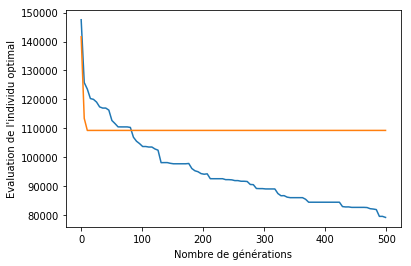

Evaluation optimale algorithme génétique : 79186.0
Evaluation optimale algorithme mémétique : 109266.0


In [14]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
evaluations_g = []
evaluations_m = []
individuOptimal_g,nbg,evaluations_g = algorithme_genetique(N,NbG,pm,cities, nbCities)
individuOptimal_m,nbg,evaluations_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)


new_nbg = np.linspace(min(nbg),max(nbg),100)

evaluations_g_smooth = spline(nbg,evaluations_g,new_nbg)
evaluations_m_smooth = spline(nbg,evaluations_m,new_nbg)


plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,evaluations_g_smooth,label="Algorithme génétique")
plt.plot(new_nbg,evaluations_m_smooth,label ="Algorithme mémétique")
plt.show()

print("Evaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

In [15]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 109299.0
Evaluation optimale algorithme mémétique : 115248.0


In [16]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 97995.0
Evaluation optimale algorithme mémétique : 105663.0


In [17]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 90843.0
Evaluation optimale algorithme mémétique : 115560.0


In [39]:
instance = "kroD100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 105045.0
Evaluation optimale algorithme mémétique : 110153.0


In [57]:
instance = "kroE100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 108266.0
Evaluation optimale algorithme mémétique : 112203.0


Cette première version de l'algorithme mémétique ne fournissant pas les résultats escomptés (stagnation et obtention de solutions moins bonnes qu'avec l'algorithme génétique simple) nous avons choisi d'implémenter une variante de celui-ci : dans cette variante nous appliquons l’opérateur de mutation aux deux fils créés puis nous réalisons une recherche locale sur ceux-ci.

In [20]:
def algorithme_memetique2(N, NbG, pm, cities, nbCities):
    N = 100
    P = [] #population = ensemble de N itinéraires (= N solutions possibles pour le TSP)
    for i in range(N):
        P.append(random.sample(range(1,nbCities+1),nbCities))
    individuOptimal = P[0]
    nbg = []
    evaluations = []
    for k in range(NbG):
        nbg.append(k)
        F = [] #liste des fitness de chaque individu de la population
        for i in range(N):
            F.append(1/evaluation(P[i],cities))
        F_triee = sorted(F)
        f_max = F_triee[-1]
        e_min = 1/f_max
        evaluations.append(e_min)
        individuOptimal = P[F.index(f_max)]
        #print("Génération",k," --> Fitness individu optimal :",int(round(e_min)))
        F_10 = F_triee[-10:]
        newP = []
        for i in range(N//2):
            # Sélection : on choisit aléatoirement 2 individus parmi les 10 individus ayant la meilleure fitness)
            x,y = selection(F_10,F,P)
            # Croisement : on réalise un croisement à un point fondé sur le rang
            z1,z2 = croisement(x,y)
            # Mutation : on applique une recherche locale sur les individus z1 et z2 avec une probabilité pm
            if random.random() <= pm:
                z1 = mutation(z1,nbCities)
                z2 = mutation(z2,nbCities)
                #chercher dans les voisins de z1 et z2 des meileures solutions grace a la recherche locale
                #print("Recherche locale z1")
                z1 = recherche_locale(z1,cities)
                #print("Recherche locale z2")
                z2 = recherche_locale(z2,cities)
            # Insertion des nouveaux individus dans newP
            newP.append(z1)
            newP.append(z2)
        P = newP
    return individuOptimal,nbg,evaluations

Nombre de générations : 500
Pourcentage de mutation : 0.01


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


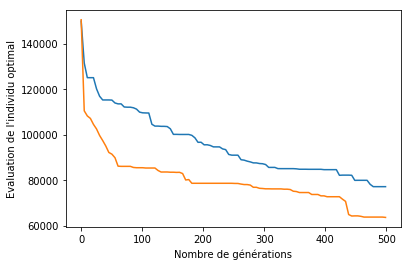

Evaluation optimale algorithme génétique : 77104.0
Evaluation optimale algorithme mémétique : 63579.0


In [41]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
evaluations_g = []
evaluations_m = []
individuOptimal_g,nbg,evaluations_g = algorithme_genetique(N,NbG,pm,cities, nbCities)
individuOptimal_m,nbg,evaluations_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)


new_nbg = np.linspace(min(nbg),max(nbg),100)

evaluations_g_smooth = spline(nbg,evaluations_g,new_nbg)
evaluations_m_smooth = spline(nbg,evaluations_m,new_nbg)


plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,evaluations_g_smooth,label="Algorithme génétique")
plt.plot(new_nbg,evaluations_m_smooth,label ="Algorithme mémétique")
plt.show()

print("Evaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

In [21]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 113236.0
Evaluation optimale algorithme mémétique : 82867.0


In [22]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 103207.0
Evaluation optimale algorithme mémétique : 82575.0


In [23]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 98465.0
Evaluation optimale algorithme mémétique : 77070.0


In [24]:
instance = "kroD100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 105223.0
Evaluation optimale algorithme mémétique : 76572.0


In [25]:
instance = "kroE100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 100
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
individuOptimal_g = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
individuOptimal_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
print("\nEvaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Nombre de générations : 100
Pourcentage de mutation : 0.01

Evaluation optimale algorithme génétique : 100599.0
Evaluation optimale algorithme mémétique : 78299.0


Les résultats sont bien plus satisfaisants avec cette variante qu'avec l'algorithme mémétique original. Cela est probablement dû au fait que les mutations créent de la diversité : on explore ainsi d'autres zones de l'espace des solutions et l'on tend ainsi vers un optimum global (pas de phénomène de stagnation au niveau d'un optimum local).

#### Question 3

Algorithme génétique VS Algorithme mémétique

Nombre de générations : 500
Pourcentage de mutation : 0.01


/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/home/madina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


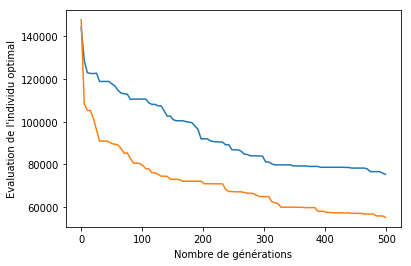

Evaluation optimale algorithme génétique : 75313.0
Evaluation optimale algorithme mémétique : 55182.0


In [58]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
nbg = []
evaluations_g = []
evaluations_m = []
individuOptimal_g,nbg,evaluations_g = algorithme_genetique(N,NbG,pm,cities, nbCities)
individuOptimal_m,nbg,evaluations_m = algorithme_memetique2(N,NbG,pm,cities, nbCities)


new_nbg = np.linspace(min(nbg),max(nbg),100)

evaluations_g_smooth = spline(nbg,evaluations_g,new_nbg)
evaluations_m_smooth = spline(nbg,evaluations_m,new_nbg)


plt.xlabel('Nombre de générations')
plt.ylabel("Evaluation de l'individu optimal")
plt.plot(new_nbg,evaluations_g_smooth,label="Algorithme génétique")
plt.plot(new_nbg,evaluations_m_smooth,label ="Algorithme mémétique")
plt.show()
print("Evaluation optimale algorithme génétique :",evaluation(individuOptimal_g,cities))
print("Evaluation optimale algorithme mémétique :",evaluation(individuOptimal_m,cities))

Instance kroA100.tsp

*Algorithme génétique*

In [27]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 82662.0
Temps de calcul : 15.819402999999966 s


*Amélioration grâce à la recherche locale*

In [28]:
tdebut = time.clock()
individuOptimal = recherche_locale(individuOptimal,cities)
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Evaluation optimale : 78287.0
Temps de calcul : 1.0690319999999929 s


*Première version de l'algorithme mémétique*

In [29]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 111565.0
Temps de calcul : 47.09680400000002 s


*Deuxième version de l'algorithme mémétique*

In [30]:
instance = "kroA100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 68153.0
Temps de calcul : 126.07362 s


Instance kroB100.tsp

*Algorithme génétique*

In [31]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 74955.0
Temps de calcul : 15.441214999999943 s


*Amélioration grâce à la recherche locale*

In [32]:
tdebut = time.clock()
individuOptimal = recherche_locale(individuOptimal,cities)
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Evaluation optimale : 70105.0
Temps de calcul : 0.8312760000000026 s


*Première version de l'algorithme mémétique*

In [33]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 108078.0
Temps de calcul : 46.94741099999999 s


*Deuxième version de l'algorithme mémétique*

In [34]:
instance = "kroB100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 52373.0
Temps de calcul : 123.46342000000004 s


Instance kroC100.tsp

*Algorithme génétique*

In [35]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_genetique(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 88290.0
Temps de calcul : 15.154791000000046 s


*Amélioration grâce à la recherche locale*

In [36]:
tdebut = time.clock()
individuOptimal = recherche_locale(individuOptimal,cities)
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Evaluation optimale : 84624.0
Temps de calcul : 0.8179609999999684 s


*Première version de l'algorithme mémétique*

In [37]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique1(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 116223.0
Temps de calcul : 56.35985000000005 s


*Deuxième version de l'algorithme mémétique*

In [38]:
instance = "kroC100.tsp"
data = read_tsp_data(instance)
nbCities = int(detect_dimension(data))
cities = read_tsp(nbCities,data)
N = 100
NbG = 500
pm = 0.01
print("Nombre de générations :",NbG)
print("Pourcentage de mutation :",pm)
tdebut = time.clock()
individuOptimal = algorithme_memetique2(N,NbG,pm,cities, nbCities)[0]
tfin = time.clock()
t = tfin-tdebut
print("Evaluation optimale :",evaluation(individuOptimal,cities))
print("Temps de calcul :",t,"s")

Nombre de générations : 500
Pourcentage de mutation : 0.01
Evaluation optimale : 60862.0
Temps de calcul : 123.527825 s


#### Conclusion

L'algorithme génétique permet d'obtenir une solution intéressante mais améliorable avec une recherche locale. La deuxième version de l'algorithme mémétique implémentée permet d'obtenir des solutions encore meilleures. Pour un nombre de génération identique, l'algorithme mémétique est ainsi plus performant que l'algorithme génétique (et que l'algorithme génétique suivi d'une recherche locale). Il est cependant beaucoup plus coûteux en temps que l'algorithme génétique (environ 8 fois plus de temps pour produire 500 générations).